### Import libraries and features 

In [1]:
import gc
import sys
import os 
import pandas as pd 
import numpy as np 
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Machine_Learning/scripts/")

In [12]:
from util import *
from carPrice import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import data and split into train and test 

In [5]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_onehot_data.csv")

### garbage collect

In [6]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


### Generate a base model first 

In [7]:
base_model = ElasticNet(random_state=2020)

In [8]:
carPrice1 = carPrice(data,base_model)

In [9]:
X_train, X_test,y_train,y_test = carPrice1.data_split(1988,0.1)

In [14]:
carPrice1.regression_metrics(X_train,y_train,X_test,y_test)

,r2_score,rmse,price_diff_abs_max
train,0.552557,6584.231121,2136.678925
test,0.535786,6865.069706,1126.375198


### Base model predicts r2 score of ~0.55. Not terrible but a root mean squared error of 6800 for a used car price is quite terrible. Let's perform gridsearch to improve the results

### Key parameters

* alpha: default 1 
* l1__ratio: default 0.5 
* max_iter: default 1000
* tol: default 1e-5

In [15]:
params = {
    "alpha":[0.0005,0.005,0.05],
    "l1_ratio":[1,0],
    "max_iter":[1000,2000],
    "tol":[1e-4,5e-5]
}

In [16]:
carPrice1.paramSearch(params,X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=22)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:   36.9s
[Parallel(n_jobs=22)]: Done 120 out of 120 | elapsed: 13.1min finished


In [17]:
carPrice1.regression_metrics(X_train,y_train,X_test,y_test)

,r2_score,rmse,price_diff_abs_max
train,0.841081,3923.949957,1814.554403
test,0.823081,4238.119220,424.366361


In [18]:
carPrice1.gridResult.best_params_

{'alpha': 0.005, 'l1_ratio': 1, 'max_iter': 1000, 'tol': 0.0001}

### Better than before but 4049 is very high error as well. 

### Let's look at feature importances and which samples have bad results

### Coefficients and look for feature ranking

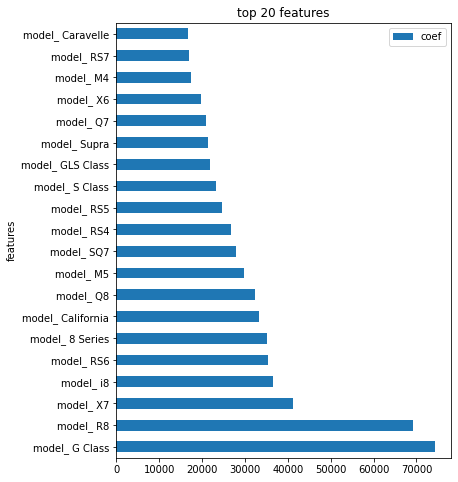

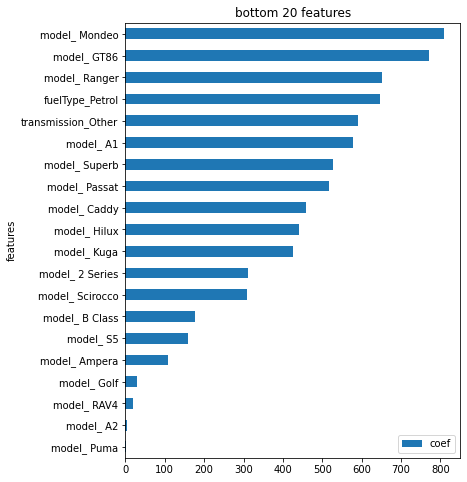

In [19]:
feature_table = carPrice1.linear_feature_importance()

### Remove features with very low coef to see if it improve performance. 

In [ ]:
features_remove = feature_table.sort_values("score").head(5).features
X_train_trimmed,X_test_trimmed = X_train.drop(features_remove,axis=1),X_test.drop(features_remove,axis=1)

In [ ]:
base_model.fit(X_train_trimmed,y_train)

In [ ]:
regression_metrics(base_model,X_train_trimmed,y_train,X_test_trimmed,y_test)

### Try gridsearch again

In [ ]:
searchGrid.fit(X_train_trimmed,y_train)

In [ ]:
searchGrid.best_score_

In [ ]:
searchGrid.best_params_

In [ ]:
model_trimmed = searchGrid.best_estimator_

In [ ]:
regression_metrics(model_trimmed,X_train_trimmed,y_train,X_test_trimmed,y_test)

### Similar performance but with less features
### Look at examples where the price is way off 

In [ ]:
price_diff_table = price_diff(model_trimmed,features.drop(features_remove,axis=1),y)

### There are many features narrow down to non model related features

In [ ]:
sub_features = [f for f in features.columns if "model" not in f]

In [ ]:
price_diff_table.sort_values("price_diff_abs",ascending=False)[:1000][sub_features].describe()

In [ ]:
price_diff_table.sort_values("price_diff_abs",ascending=False)[:5][sub_features+["price_diff_pct"]]

In [ ]:
price_diff_table.sort_values("price_diff_abs")[:1000][sub_features].describe()

In [ ]:
price_diff_table.sort_values("price_diff_abs")[:5][sub_features+["price_diff_pct"]]

### summary:

* cars that are older tend to be harder to predict for the price. 
* cars with medium size engine, semi automatic transmission tend to be easier to predict for the price. 

In [ ]:
price_diff_table.price_diff_abs.describe()

### Overally not a bad first model:
* 17% price difference 
* 22% price different at 75% quantile. 
* car price appears to be very dependent upon the brand as well

_____